# **Smallpt in xeus-cpp-lite**

### *An example inspired by Kevin Beason's [smallpt](https://www.kevinbeason.com/smallpt/)*

In [1]:
// LICENSE
//
// Copyright (c) 2006-2008 Kevin Beason (kevin.beason@gmail.com)
//
// Permission is hereby granted, free of charge, to any person obtaining
// a copy of this software and associated documentation files (the
// "Software"), to deal in the Software without restriction, including
// without limitation the rights to use, copy, modify, merge, publish,
// distribute, sublicense, and/or sell copies of the Software, and to
// permit persons to whom the Software is furnished to do so, subject to
// the following conditions:
//
// The above copyright notice and this permission notice shall be included
// in all copies or substantial portions of the Software.
//
// THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
// EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
// MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
// IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY
// CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
// TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
// SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#include <math.h>
#include <stdlib.h>
#include <vector>

struct Vec {
  double x, y, z; // position, also color (r,g,b)
  Vec(double x_ = 0, double y_ = 0, double z_ = 0) {
    x = x_;
    y = y_;
    z = z_;
  }
  Vec operator+(const Vec &b) const { return Vec(x + b.x, y + b.y, z + b.z); }
  Vec operator-(const Vec &b) const { return Vec(x - b.x, y - b.y, z - b.z); }
  Vec operator*(double b) const { return Vec(x * b, y * b, z * b); }
  Vec mult(const Vec &b) const { return Vec(x * b.x, y * b.y, z * b.z); }
  Vec &norm() { return *this = *this * (1 / sqrt(x * x + y * y + z * z)); }
  double dot(const Vec &b) const { return x * b.x + y * b.y + z * b.z; }
  Vec operator%(Vec &b) { // cross
    return Vec(y * b.z - z * b.y, z * b.x - x * b.z, x * b.y - y * b.x);
  }
};
struct Ray {
  Vec o, d;
  Ray(Vec o_, Vec d_) : o(o_), d(d_) {}
};
enum Refl_t { DIFF, SPEC, REFR }; // material types, used in radiance()
struct Sphere {
  double rad;  // radius
  Vec p, e, c; // position, emission, color
  Refl_t refl; // reflection type (DIFFuse, SPECular, REFRactive)
  Sphere(double rad_, Vec p_, Vec e_, Vec c_, Refl_t refl_)
      : rad(rad_), p(p_), e(e_), c(c_), refl(refl_) {}
  double intersect(const Ray &r) const { // returns distance, 0 if nohit
    Vec op = p - r.o; // Solve t^2*d.d + 2*t*(o-p).d + (o-p).(o-p)-R^2 = 0
    double t, eps = 1e-4, b = op.dot(r.d), det = b * b - op.dot(op) + rad * rad;
    if (det < 0)
      return 0;
    else
      det = sqrt(det);
    return (t = b - det) > eps ? t : ((t = b + det) > eps ? t : 0);
  }
};

In [2]:
std::vector<Sphere> spheres = {
    // Scene: radius, position, emission, color, material
    Sphere(1e5, Vec(1e5 + 1, 40.8, 81.6), Vec(), Vec(.75, .25, .25),
           DIFF), // Left
    Sphere(1e5, Vec(-1e5 + 99, 40.8, 81.6), Vec(), Vec(.25, .25, .75),
           DIFF),                                                     // Rght
    Sphere(1e5, Vec(50, 40.8, 1e5), Vec(), Vec(.75, .75, .75), DIFF), // Back
    Sphere(1e5, Vec(50, 40.8, -1e5 + 170), Vec(), Vec(), DIFF),       // Frnt
    Sphere(1e5, Vec(50, 1e5, 81.6), Vec(), Vec(.75, .75, .75), DIFF), // Botm
    Sphere(1e5, Vec(50, -1e5 + 81.6, 81.6), Vec(), Vec(.75, .75, .75),
           DIFF),                                                      // Top
    Sphere(16.5, Vec(27, 16.5, 47), Vec(), Vec(1, 1, 1) * .999, SPEC), // Mirr
    Sphere(16.5, Vec(73, 16.5, 78), Vec(), Vec(1, 1, 1) * .999, REFR), // Glas
    Sphere(600, Vec(50, 681.6 - .27, 81.6), Vec(12, 12, 12), Vec(),
           DIFF) // Lite
};

inline double clamp(double x) { return x < 0 ? 0 : x > 1 ? 1 : x; }
inline int toInt(double x) { return int(pow(clamp(x), 1 / 2.2) * 255 + .5); }
inline bool intersect(const Ray &r, double &t, int &id) {
  double n = spheres.size(), d, inf = t = 1e20;
  for (int i = int(n); i--;)
    if ((d = spheres[i].intersect(r)) && d < t) {
      t = d;
      id = i;
    }
  return t < inf;
}

In [3]:
Vec radiance(const Ray &r, int depth, unsigned short *Xi) {
  double t;   // distance to intersection
  int id = 0; // id of intersected object
  if (!intersect(r, t, id))
    return Vec();                  // if miss, return black
  const Sphere &obj = spheres[id]; // the hit object
  Vec x = r.o + r.d * t, n = (x - obj.p).norm(),
      nl = n.dot(r.d) < 0 ? n : n * -1, f = obj.c;
  double p = f.x > f.y && f.x > f.z ? f.x : f.y > f.z ? f.y : f.z; // max refl
  if (++depth > 5) {
    if (erand48(Xi) < p) {
      f = f * (1 / p);
    } else {
      return obj.e; // R.R.
    }
  }
  if (obj.refl == DIFF) { // Ideal DIFFUSE reflection
    double r1 = 2 * M_PI * erand48(Xi), r2 = erand48(Xi), r2s = sqrt(r2);
    Vec w = nl, u = ((fabs(w.x) > .1 ? Vec(0, 1) : Vec(1)) % w).norm(),
        v = w % u;
    Vec d = (u * cos(r1) * r2s + v * sin(r1) * r2s + w * sqrt(1 - r2)).norm();
    return obj.e + f.mult(radiance(Ray(x, d), depth, Xi));
  } else if (obj.refl == SPEC) // Ideal SPECULAR reflection
    return obj.e +
           f.mult(radiance(Ray(x, r.d - n * 2 * n.dot(r.d)), depth, Xi));
  Ray reflRay(x, r.d - n * 2 * n.dot(r.d)); // Ideal dielectric REFRACTION
  bool into = n.dot(nl) > 0;                // Ray from outside going in?
  double nc = 1, nt = 1.5, nnt = into ? nc / nt : nt / nc, ddn = r.d.dot(nl),
         cos2t;
  if ((cos2t = 1 - nnt * nnt * (1 - ddn * ddn)) <
      0) // Total internal reflection
    return obj.e + f.mult(radiance(reflRay, depth, Xi));
  Vec tdir =
      (r.d * nnt - n * ((into ? 1 : -1) * (ddn * nnt + sqrt(cos2t)))).norm();
  double a = nt - nc, b = nt + nc, R0 = a * a / (b * b),
         c = 1 - (into ? -ddn : tdir.dot(n));
  double Re = R0 + (1 - R0) * c * c * c * c * c, Tr = 1 - Re, P = .25 + .5 * Re,
         RP = Re / P, TP = Tr / (1 - P);
  return obj.e +
         f.mult(depth > 2
                    ? (erand48(Xi) < P ? // Russian roulette
                           radiance(reflRay, depth, Xi) * RP
                                       : radiance(Ray(x, tdir), depth, Xi) * TP)
                    : radiance(reflRay, depth, Xi) * Re +
                          radiance(Ray(x, tdir), depth, Xi) * Tr);
}

In [4]:
#include <SDL2/SDL.h>
#include <string>
#include <fstream>
#include <sstream>
#include <iostream>
#include "nlohmann/json.hpp"
#include "xeus/xbase64.hpp"
#include "xcpp/xdisplay.hpp"

namespace nl = nlohmann;

namespace im
{
    struct image
    {   
        inline image(const std::string& filename)
        {
            std::ifstream fin(filename, std::ios::binary);   
            m_buffer << fin.rdbuf();
        }
        
        std::stringstream m_buffer;
    };
    
    nl::json mime_bundle_repr(const image& i)
    {
        auto bundle = nl::json::object();
        bundle["image/bmp"] = xeus::base64encode(i.m_buffer.str());
        return bundle;
    }
}

// Function to save SDL surface as BMP persistently
void save_bmp_to_filesystem(SDL_Surface* surface, const std::string& filename)
{
    if (surface)
    {
        if (SDL_SaveBMP(surface, filename.c_str()) == 0)
        {
            std::cout << "[DEBUG] Surface saved to " << filename << std::endl;
        }
        else
        {
            std::cerr << "[ERROR] Failed to save BMP to " << filename << ": " << SDL_GetError() << std::endl;
        }
    }
    else
    {
        std::cerr << "[ERROR] Surface is null, cannot save BMP." << std::endl;
    }
}

// Function to encode an SDL surface and render it in Jupyter
void render_sdl_surface_to_jupyter(SDL_Surface* surface, const std::string& filename)
{

    if (!surface)
    {
        std::cerr << "[ERROR] Surface is null" << std::endl;
        return;
    }

    std::cout << "[DEBUG] Surface created successfully" << std::endl;

    im::image output(filename);
    xcpp::display(output);
    
    // Cleanup
    SDL_FreeSurface(surface);
    std::cout << "[DEBUG] Surface freed" << std::endl;
    remove(filename.c_str());
}

[DEBUG] Initializing SDL
[DEBUG] SDL initialized successfully
[DEBUG] Dimensions: 320x240, Samples: 16
[DEBUG] SDL surface created successfully
[DEBUG] The image should be on your screen soon
[DEBUG] Mapped pixel buffer to surface
[DEBUG] Surface saved to render.bmp
[DEBUG] Surface created successfully


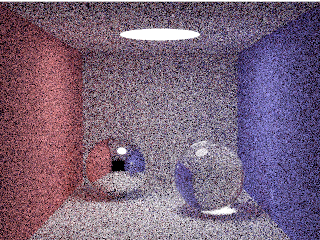

[DEBUG] Surface freed
[DEBUG] Exiting main


In [5]:
int main() {
    // Debug: Initialization
    std::cout << "[DEBUG] Initializing SDL" << std::endl;

    if (SDL_Init(SDL_INIT_EVENTS) != 0) {
        std::cerr << "[ERROR] SDL_Init failed: " << SDL_GetError() << std::endl;
        return 1;
    }
    std::cout << "[DEBUG] SDL initialized successfully" << std::endl;

    // Define width, height, and samples
    int w = 320, h = 240, samps = 16; // # samples
    std::cout << "[DEBUG] Dimensions: " << w << "x" << h << ", Samples: " << samps << std::endl;

    // Create an off-screen surface
    SDL_Surface* surface = SDL_CreateRGBSurfaceWithFormat(0, w, h, 32, SDL_PIXELFORMAT_RGBA32);
    if (!surface) {
        std::cerr << "[ERROR] Failed to create SDL surface: " << SDL_GetError() << std::endl;
        SDL_Quit();
        return 1;
    }
    std::cout << "[DEBUG] SDL surface created successfully" << std::endl;

    // Prepare the camera and pixel buffer
    Ray cam(Vec(50, 52, 295.6), Vec(0, -0.042612, -1).norm()); // cam pos, dir
    Vec cx = Vec(w * .5135 / h), cy = (cx % cam.d).norm() * .5135, r,
        *c = new Vec[w * h];

    std::cout << "[DEBUG] The image should be on your screen soon" << std::endl;
    // Render the scene
    for (int y = 0; y < h; y++) { // Loop over image rows
        unsigned short x, Xi[3] = {0, 0, static_cast<unsigned short>(y * y * y)};
        for (x = 0; x < w; x++) { // Loop cols
            int sy, i = (h - y - 1) * w + x;
            for (sy = 0; sy < 2; sy++) { // 2x2 subpixel rows
                int sx;
                for (sx = 0; sx < 2; sx++, r = Vec()) { // 2x2 subpixel cols
                    for (int s = 0; s < samps; s++) { // Subpixel sampling
                        double r1 = 2 * erand48(Xi),
                               dx = r1 < 1 ? sqrt(r1) - 1 : 1 - sqrt(2 - r1);
                        double r2 = 2 * erand48(Xi),
                               dy = r2 < 1 ? sqrt(r2) - 1 : 1 - sqrt(2 - r2);
                        Vec d = cx * (((sx + .5 + dx) / 2 + x) / w - .5) +
                                cy * (((sy + .5 + dy) / 2 + y) / h - .5) + cam.d;
                        r = r + radiance(Ray(cam.o + d * 140, d.norm()), 0, Xi) * (1. / samps);
                    }
                    c[i] = c[i] + Vec(clamp(r.x), clamp(r.y), clamp(r.z)) * .25;
                }
            }
        }
    }

    // Map the pixel buffer to the SDL surface
    uint8_t* pixels = (uint8_t*)surface->pixels;
    for (int i = 0; i < w * h; i++) {
        uint32_t* pixel_ptr = (uint32_t*)pixels + i;
        *pixel_ptr = SDL_MapRGBA(surface->format, 
                                 toInt(c[i].x), // Red
                                 toInt(c[i].y), // Green
                                 toInt(c[i].z), // Blue
                                 255);          // Alpha
    }
    std::cout << "[DEBUG] Mapped pixel buffer to surface" << std::endl;

    // Save the BMP to the filesystem
    const std::string bmp_filename = "render.bmp";
    save_bmp_to_filesystem(surface, bmp_filename);

    // Render the surface to Jupyter
    render_sdl_surface_to_jupyter(surface, bmp_filename);

    // Cleanup
    delete[] c;
    SDL_Quit();
    std::cout << "[DEBUG] Exiting main" << std::endl;

    return 0;
}

main();